In [ ]:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tmollick95/iMapInvasives/blob/master/Code/Data%20download%20and%20preprocess%20code.ipynb)

## Leveraging machine learning to confirm invasive species reports

#### Mount Google Drive to access the dataset

In [ ]:
#attach to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install required Python libraries


In [ ]:
!pip install geopandas
!pip install seaborn
!pip install earthpy

### Importing python librariers

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import os
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from io import BytesIO
import math
import json
from IPython.display import display, HTML

In [ ]:
# Set the working directory
os.chdir("/content/drive/My Drive/iMapInvasives_datasets")

# Verify the current working directory
print("Current working directory:", os.getcwd())
os.listdir()

Current working directory: /content/drive/My Drive/iMapInvasives_datasets


['iMapInvasives_confirmed_reports',
 'USA_Shapefile',
 'New_York_iMap_confirmed_records_from_year_2000.csv']

### Map the confirmed records of iMapInvasives
Get the NY_Presence_point_confirm.shp shapefile from https://drive.google.com/drive/folders/1DeRGgMZagojDltKY99oYusAsaqRV7ZMs?usp=drive_link Google Drive link. Extract the Zip file and change the directory to run this code.

In [ ]:
path_to_shapefile = "/content/drive/My Drive/iMapInvasives_datasets/iMapInvasives_confirmed_reports/NY_Presence_point_confirm.shp"
slf = gpd.read_file(path_to_shapefile, encoding='ISO-8859-1')
slf.head()

OBJECTID            scientific            common_nam observatio  \
0         4    Lycorma delicatula    Spotted Lanternfly 2022-08-01   
1         5  Phalaris arundinacea      Reed Canarygrass 2022-08-08   
2         6   Elaeagnus umbellata          Autumn Olive 2022-08-21   
3      1411    Rhamnus cathartica      Common Buckthorn 2016-07-13   
4      1674    Euonymus europaeus  European Spindletree 2016-10-04   

   number_fou         observer  has_photo_  imap_id species_ty  growth_hab  \
0           0   Charles Holmes           1  1285436     Animal  Plant Pest   
1           0  Priscilla Titus           1  1285675      Plant   Graminoid   
2           0     Monika  Wood           1  1288329      Plant       Shrub   
3           0  Julie Grinstead           1   494484      Plant        Tree   
4           0  Danielle Slavis           1   510862      Plant       Shrub   

   ... jurisdic_1 project_id  approximat approxim_1  present_sp   habitat_ty  \
0  ...       1499       None           0       None     1295072  Terrestrial   
1  ...       1410        399           0       None     1295381  Terrestrial   
2  ...       1146       1025           0       None     1298280  Terrestrial   
3  ...       1144        376           0       None      494484  Terrestrial   
4  ...       1128       None           0       None      510862  Terrestrial   

   presence_i  Longitude  Latitude                        geometry  
0     1285436 -64.306039  2.983061  POINT (1695337.874 335578.009)  
1     1285675 -64.499116  4.378488  POINT (1671642.409 492231.254)  
2     1288329 -66.422054  3.560139  POINT (1456256.162 397977.851)  
3      494484 -66.058779  4.529017   POINT (1495874.55 506776.864)  
4      510862 -65.926975  4.620081  POINT (1510547.195 517154.886)  

[5 rows x 24 columns]

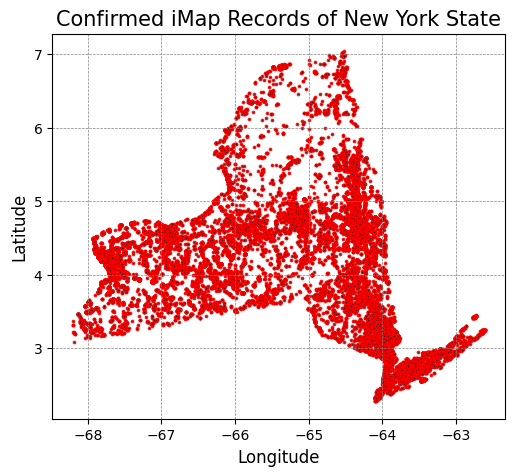

In [ ]:
from shapely.geometry import Point


# Create a GeoDataFrame with points from Longitude and Latitude columns
geometry = [Point(xy) for xy in zip(slf['Longitude'], slf['Latitude'])]
slf_corrected = gpd.GeoDataFrame(slf, geometry=geometry)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the points with specified color and edge
slf_corrected.plot(ax=ax, color='black', edgecolor='red', markersize=3, alpha=0.8)

# Set the x and y axis labels to Longitude and Latitude
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.set_title("Confirmed iMap Records of New York State", fontsize=15)

# Add a grid
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()


### Read csv file of New York State iMapInvasives confirmed records

#### The CSV file is in GitHub Dataset folder of iMapInvasives repository. To run this code download the CSV file and change the file path.

In [ ]:
ny = pd.read_csv("New_York_iMap_confirmed_records_from_year_2000.csv", encoding="ISO-8859-1")
ny.head()

scientific  \
0                            Rosa multiflora   
1                 Rosa lucieae (wichuraiana)   
2             Lonicera spp (species unknown)   
3                        Ailanthus altissima   
4  Amynthas-Metaphire spp. (species unknown)   

                                          common_nam  observatio  number_fou  \
0                                    Multiflora Rose  12/11/2022           4   
1                                      Memorial Rose    7/1/2021           1   
2                      Honeysuckle (species unknown)    6/1/2023           0   
3                          Tree-of-heaven, Ailanthus   7/15/2021           0   
4  Jumping Worms (species unknown), Asian jumping...   8/16/2021           0   

          observer species_ty growth_hab jurisdicti      county  \
0    Elliott Adams      Plant      Shrub   New York  Montgomery   
1      Steve Young      Plant        NaN   New York     Suffolk   
2  Bethany Holland      Plant      Shrub   New York     Ontario   
3  Brittany Hernon      Plant       Tree   New York        Erie   
4  Selma Rosenthal     Animal        NaN   New York    Onondaga   

       regional_m  present_sp   habitat_ty  presence_i  
0  Capital Region     1327710  Terrestrial     1316659  
1          LIISMA     1257468  Terrestrial     1249313  
2    Finger Lakes     1393835  Terrestrial     1375738  
3      Western NY     1157922  Terrestrial     1151046  
4    Finger Lakes     1166339  Terrestrial     1159257

### Summarize and count the number of records in every species to get an overview

In [ ]:
# Group by 'scientific' and 'common_nam' columns and count occurrences
species_count_df = ny.groupby(['scientific', 'common_nam']).size().reset_index(name='Count')

# Sort by 'Count' in descending order and get the top 15 rows
top_species_df = species_count_df.sort_values(by='Count', ascending=False).head(15)

# Display the top 10 rows
print(top_species_df)


                                            scientific  \
182                     Lonicera spp (species unknown)   
14                                 Ailanthus altissima   
291                                    Rosa multiflora   
10                                      Adelges tsugae   
281  Reynoutria japonica var. japonica : Fallopia j...   
285                                 Rhamnus cathartica   
253                Phragmites australis ssp. australis   
59                               Celastrus orbiculatus   
18                                  Alliaria petiolata   
35                                 Berberis thunbergii   
178                      Litylenchus crenatae mccannii   
194                                 Lycorma delicatula   
28                                  Artemisia vulgaris   
155                                   Iris pseudacorus   
200                                  Lythrum salicaria   

                             common_nam  Count  
182       Honeysuckle 

### Fliter 500 Spotted Lanternfly Records

In [ ]:
# Filter records where jurisdicti is "New York"
ny_records = ny[ny['jurisdicti'] == 'New York']

# Further filter the records for "Alliaria petiolata"
alliaria_records = ny_records[ny_records['scientific'] == 'Lycorma delicatula']

# Check the available counties for this species in New York
available_counties = alliaria_records['county'].unique()
print(f"Available counties for Lycorma delicatula in New York: {available_counties}")

# Evenly distribute 500 records across all counties
num_counties = len(available_counties)
records_per_county = 500 // num_counties

# Sample records evenly across counties
sampled_records = alliaria_records.groupby('county').apply(lambda x: x.sample(n=min(len(x), records_per_county), replace=False))

# If we still need more records, sample remaining from counties that have more data
remaining_records_needed = 500 - len(sampled_records)

if remaining_records_needed > 0:
    extra_records = alliaria_records[~alliaria_records.index.isin(sampled_records.index)].sample(n=remaining_records_needed, replace=False)
    sampled_records = pd.concat([sampled_records, extra_records])

# Remove multi-index caused by groupby
sampled_records = sampled_records.reset_index(drop=True)

sampled_records.head()

Available counties for Lycorma delicatula in New York: ['Westchester' 'Suffolk' 'Nassau' 'Kings' 'Richmond' 'New York' 'Rockland'
 'Orange' 'Queens' 'Broome' 'Sullivan' 'Bronx' 'Ulster' 'Tioga' 'Seneca'
 'Dutchess' 'Erie' 'Putnam' 'Albany' 'Tompkins']


<ipython-input-10-41c384851b86>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_records = alliaria_records.groupby('county').apply(lambda x: x.sample(n=min(len(x), records_per_county), replace=False))


scientific          common_nam observatio  number_fou  \
0  Lycorma delicatula  Spotted Lanternfly  8/29/2023           1   
1  Lycorma delicatula  Spotted Lanternfly  8/21/2024           0   
2  Lycorma delicatula  Spotted Lanternfly  9/21/2022           0   
3  Lycorma delicatula  Spotted Lanternfly  8/24/2023           0   
4  Lycorma delicatula  Spotted Lanternfly  2/11/2022           0   

         observer species_ty  growth_hab jurisdicti  county      regional_m  \
0     John Marino     Animal  Plant Pest   New York  Albany  Capital Region   
1     Sam Schultz     Animal  Plant Pest   New York  Albany  Capital Region   
2       Darin May     Animal  Plant Pest   New York   Bronx    Lower Hudson   
3  Public Reports     Animal  Plant Pest   New York   Bronx    Lower Hudson   
4      Emily Wein     Animal  Plant Pest   New York   Bronx    Lower Hudson   

   present_sp   habitat_ty  presence_i  
0     1368225  Terrestrial     1350954  
1     1455989  Terrestrial     1441530  
2     1307195  Terrestrial     1296965  
3     1372905  Terrestrial     1355273  
4     1259753  Terrestrial     1251434

### Request iMapInvasives API with run in Cookie based system
#### To get access to the iMap API we need to create account from https://www.imapinvasives.org/ website using email address and set a password. Here I am using my iMap email and password to access this API.

In [ ]:
import requests

imap_site = "imapinvasives"
iMap_username = "tmollick@esf.edu"
iMap_password = "URPku@130436"

login_url = r"https://{0}.natureserve.org/imap/j_spring_security_check".format(imap_site)

# Attempt to log in
print("\nAttempting to authenticate with: {0}".format(login_url))
iMapSession = requests.Session()  # This is a global variable accessed in later functions
login_response = iMapSession.post(login_url,{'j_username':iMap_username,'j_password':iMap_password})
login_response_message = "\nlogin response: {0}".format(login_response.status_code)
print(login_response_message)
login_response.raise_for_status()

# Attempt to access a record to check if log-in was successful
test_aoi_url = r"https://{0}.natureserve.org/imap/services/aoi/new".format(imap_site)
test_aoi_record = iMapSession.get(test_aoi_url)
test_aoi_record_message = "\nTest record access response: {0}".format(test_aoi_record.status_code)
print(test_aoi_record_message)

if test_aoi_record.status_code == 403:
    print("\nResponse Code 403 is most likely the result of an incorrectly entered iMap username or password.  It may also be caused by logging in as a user with insufficient permissions.")

test_aoi_record.raise_for_status()


Attempting to authenticate with: https://imapinvasives.natureserve.org/imap/j_spring_security_check

login response: 200

Test record access response: 200


### Filter iMap records which have photos uploaded by users

In [ ]:
# Read the presence IDs
record_ids = sampled_records
pre_ID = record_ids["presence_i"].tolist()  # Convert Series to list

In [ ]:
base_url = f"https://{imap_site}.natureserve.org/imap/services/presence/"

# List to store presence IDs with at least one species having a photo
presence_ids_with_photos = []

# Iterate over each presence ID
for presence_id in pre_ID:
    # Construct the full URL for each presence ID
    full_url = f"{base_url}{presence_id}"

    # Get the iMap record for this presence ID
    try:
        imap_record = iMapSession.get(full_url)  # Use the session to maintain authentication

        # Check if the request was successful
        if imap_record.status_code == 200:
            # Convert the response to a dictionary
            imap_dictionary = imap_record.json()

            # Extract all presentSpeciesId values from the speciesList
            present_species_ids = [species.get("presentSpeciesId") for species in imap_dictionary.get("speciesList", [])]

            # Filter out any None values just in case
            present_species_ids = [id for id in present_species_ids if id is not None]

            # Check if any presentSpeciesId has hasPhotoInd == True
            has_photo = any(species.get("hasPhotoInd") == True for species in imap_dictionary.get("speciesList", []))

            # If at least one presentSpeciesId has a photo, add the presence ID to the list
            if has_photo:
                presence_ids_with_photos.append(presence_id)

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while processing presence ID {presence_id}: {e}")

In [ ]:
print(presence_ids_with_photos)

[1350954, 1441530, 1296965, 1355273, 1251434, 1434907, 1308949, 1163326, 1272655, 1355266, 1275197, 1180108, 1165050, 1275482, 1275483, 1335780, 1153172, 1303171, 1164452, 1335781, 1355259, 1303110, 1335779, 1160966, 1275189, 1351709, 1289311, 1442549, 1281417, 1363058, 1291538, 1443955, 1363331, 1363335, 1434302, 1442709, 1412087, 1408723, 1249206, 1355577, 1297821, 1416974, 1413837, 1297435, 1294025, 1352559, 1350316, 1163355, 1249221, 1329058, 1273346, 1159068, 1273380, 1162081, 1272644, 1273382, 1160765, 1273684, 1162125, 1165045, 1167656, 1162130, 1167641, 1160915, 1273342, 1165037, 1355256, 1159042, 1434872, 1159904, 1329057, 1273372, 1355154, 1355161, 1339831, 1299695, 1343563, 1335834, 1341664, 1338323, 1341429, 1355058, 1341045, 1345656, 1342727, 1351236, 1159297, 1337561, 1349036, 1355059, 1335253, 1434355, 1435238, 1343538, 1343543, 1348881, 1345679, 1160930, 1160791, 1167023, 1159045, 1164110, 1362566, 1163961, 1160807, 1162110, 1163226, 1160764, 1273350, 1163951, 1162966, 

In [ ]:
presence_ids = presence_ids_with_photos

### Plot the first 10 iMap record photos


Processing presence ID: 1350954


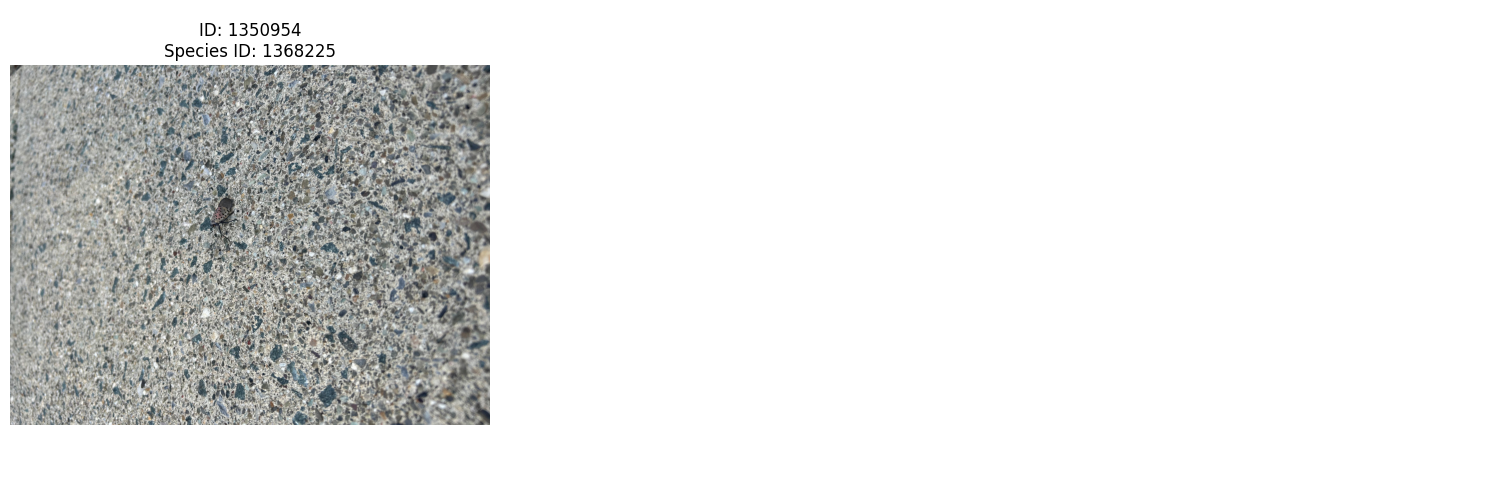


Processing presence ID: 1441530


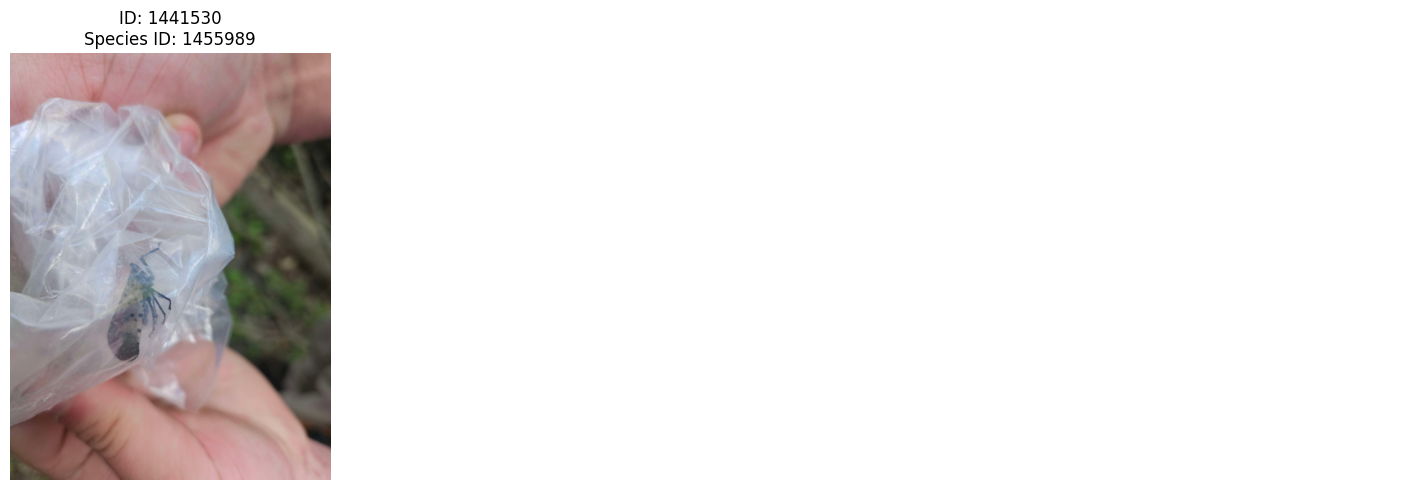


Processing presence ID: 1296965


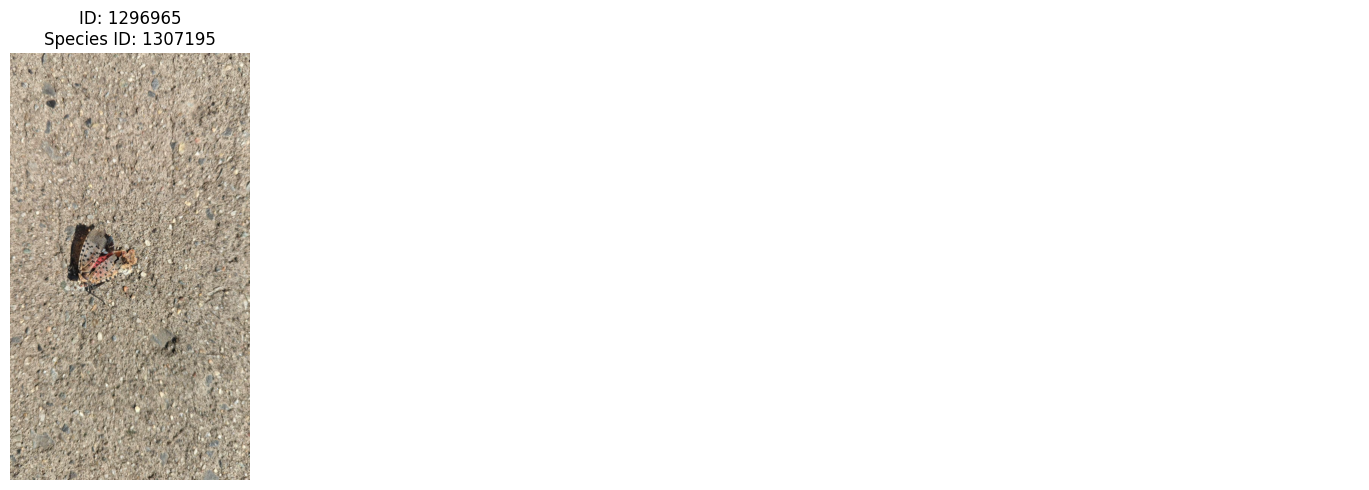


Processing presence ID: 1355273


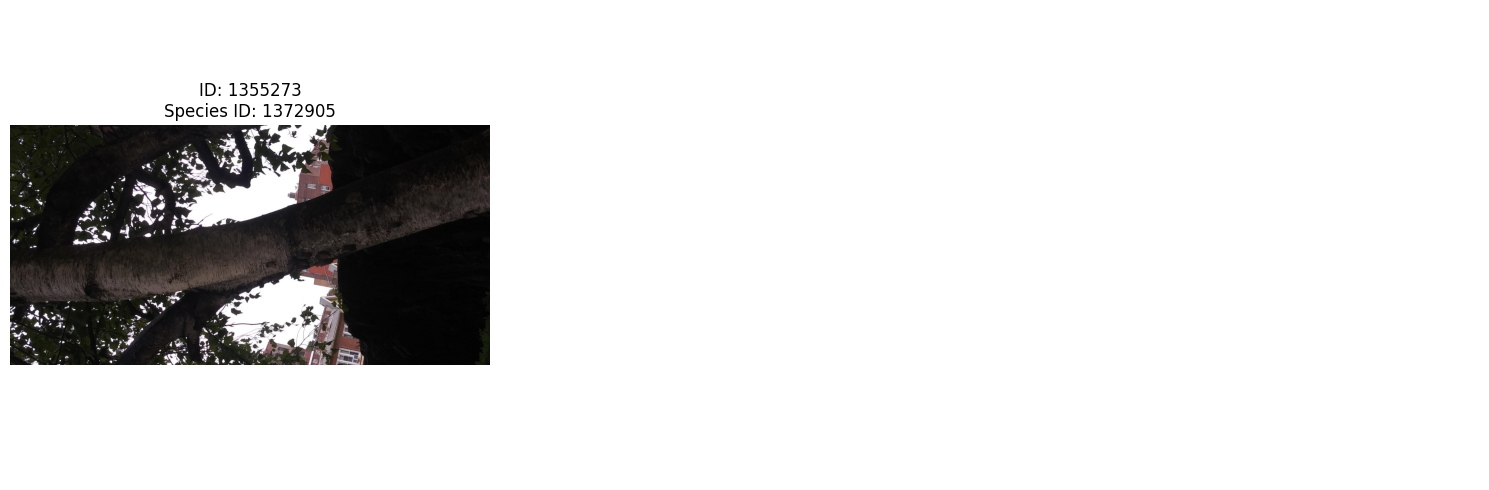


Processing presence ID: 1251434


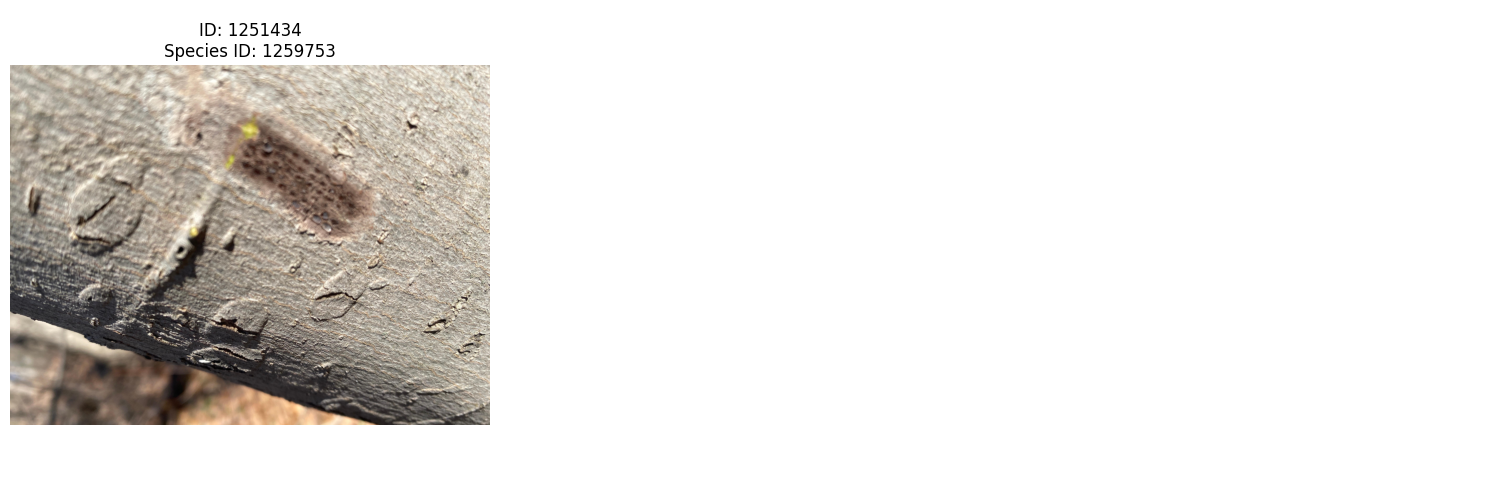


Processing presence ID: 1434907


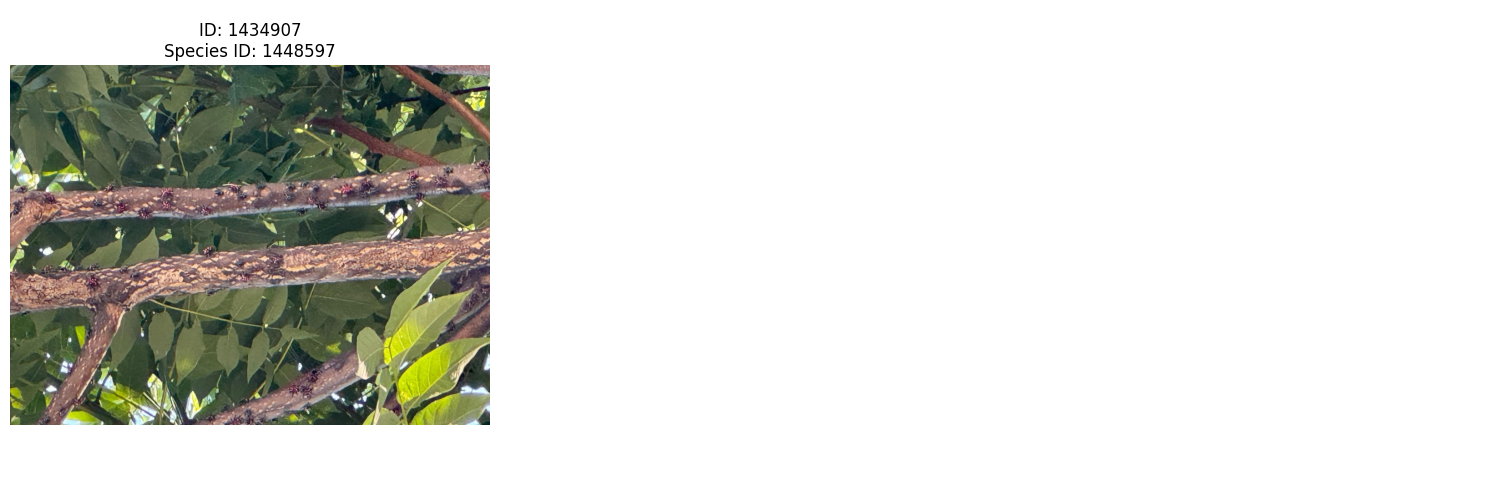


Processing presence ID: 1308949


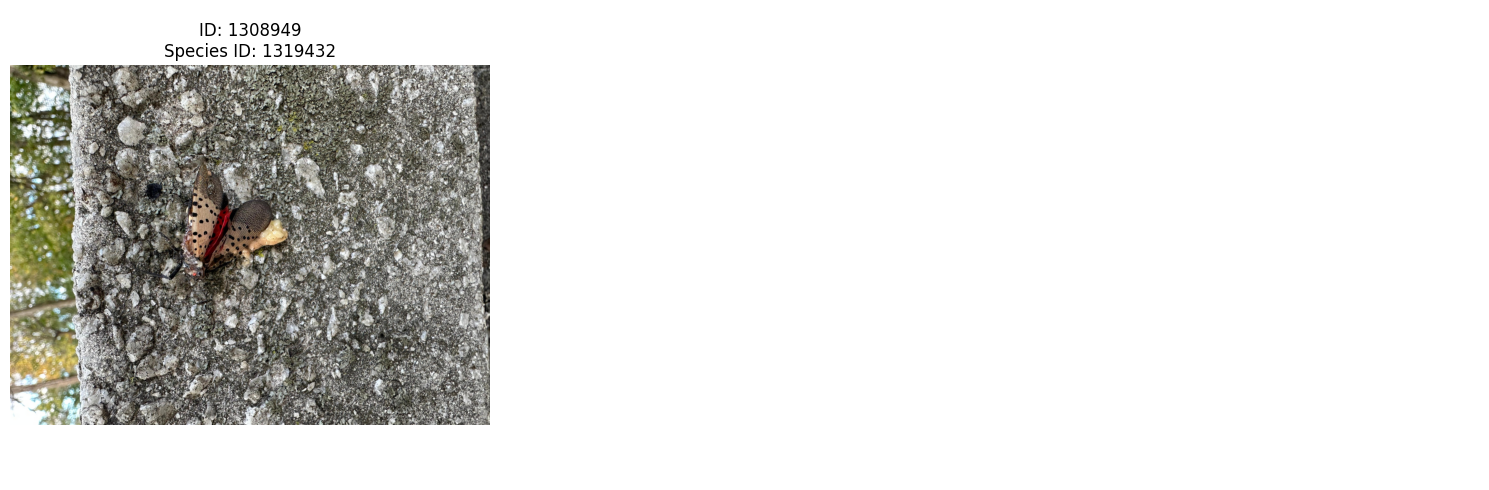


Processing presence ID: 1163326


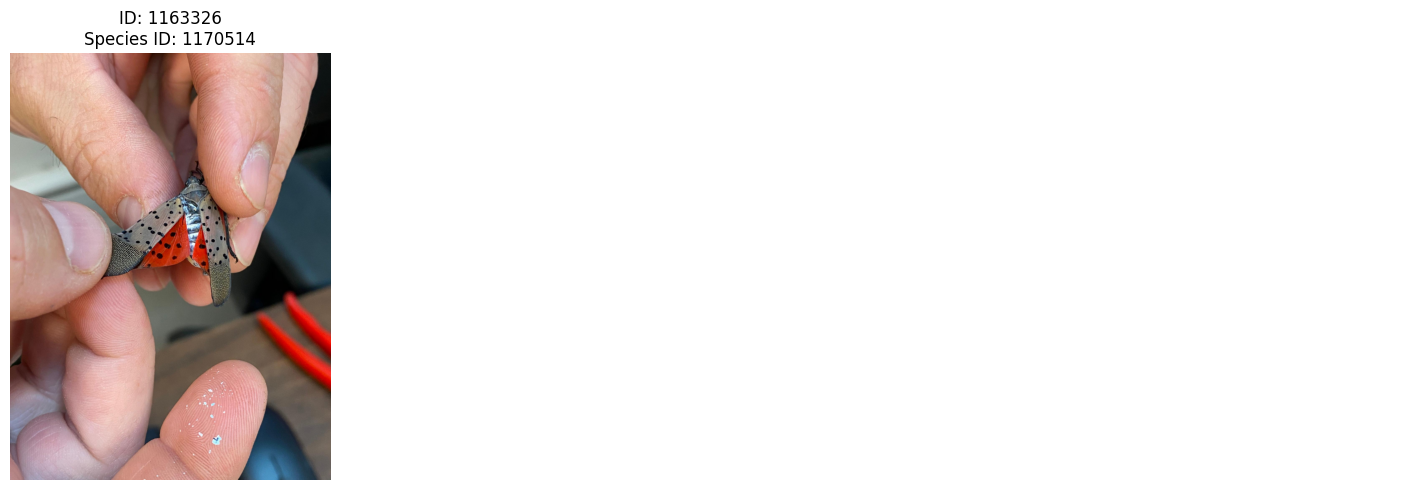


Processing presence ID: 1272655


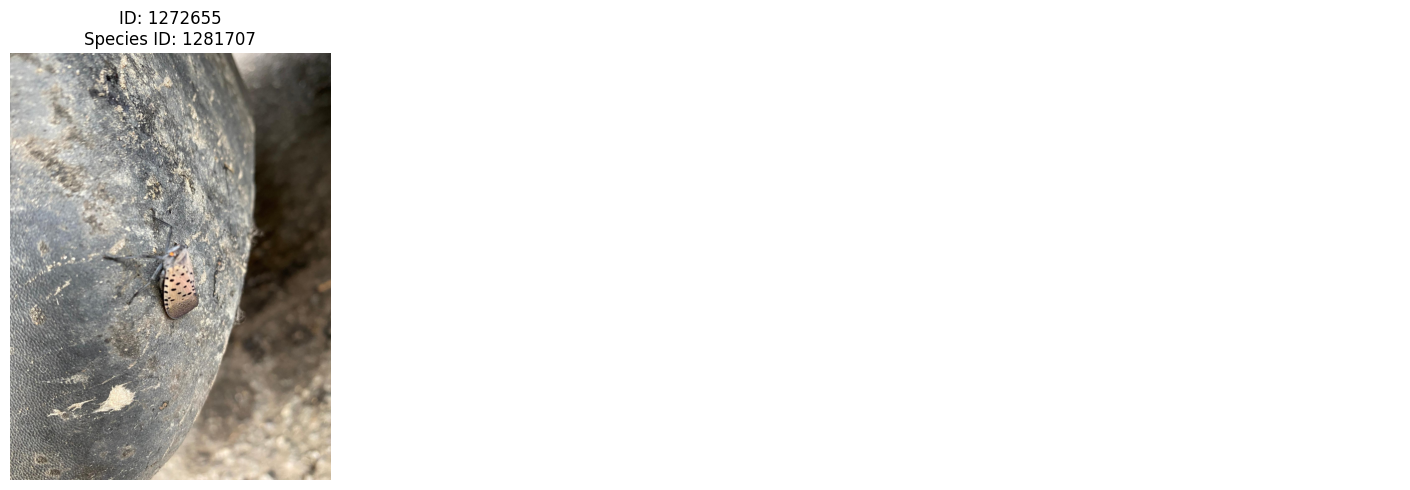


Processing presence ID: 1355266


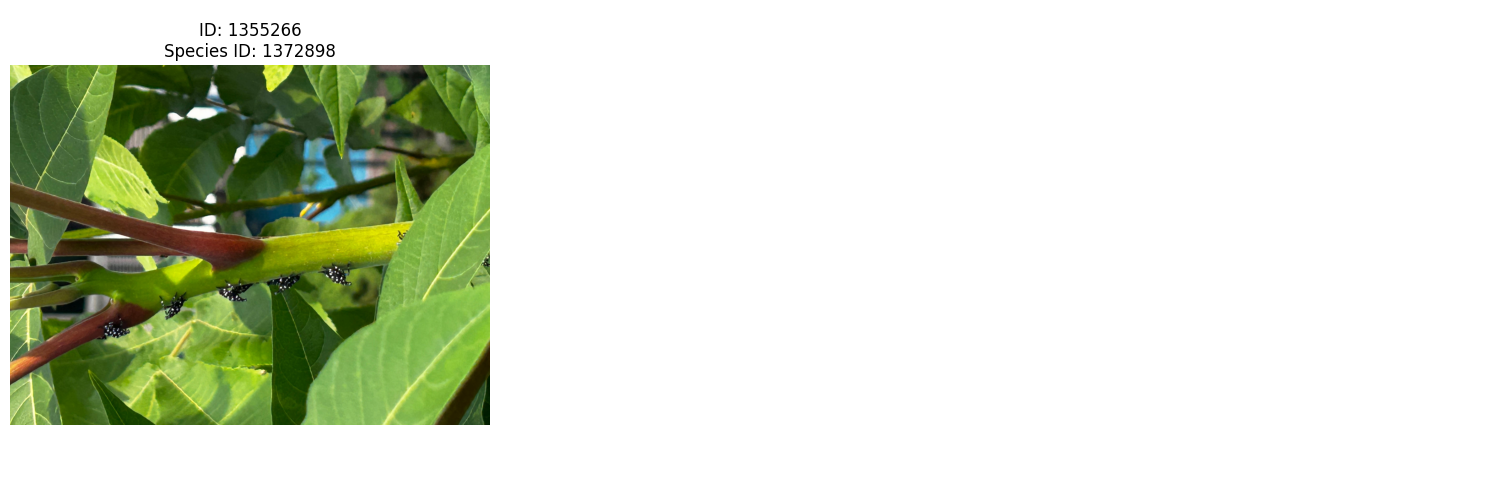

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import math

# Function to get the image from a URL, handling redirects and setting headers
def get_image_from_url(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }

    # Perform the GET request with headers and follow redirects
    response = iMapSession.get(url, headers=headers, allow_redirects=True)

    if response.status_code == 200:
        try:
            return Image.open(BytesIO(response.content))
        except Exception as e:
            print(f"Failed to open image. Error: {e}")
            return None
    else:
        print(f"Failed to retrieve image. Status code: {response.status_code}")
        return None

# Function to plot images for each presentSpeciesId in a grid with 3 columns
def plot_images_for_species(imap_dictionary, presence_id):
    species_list = imap_dictionary.get("speciesList", [])
    num_species = len(species_list)
    num_columns = 3
    num_rows = math.ceil(num_species / num_columns)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

    for i, species in enumerate(species_list):
        img = None

        # Check if the 'photos' list exists and has at least one item
        if "photos" in species and species["photos"]:
            photo_url = species["photos"][0].get("photoUrl", "")

            if photo_url and (photo_url.lower().endswith('.jpg') or photo_url.lower().endswith('.jpeg')):  # Ensure the URL is a valid .jpg or .jpeg
                img = get_image_from_url(photo_url)

        # Display the image if it was successfully retrieved
        if img:
            axs[i].imshow(img)
            axs[i].axis('off')  # Turn off the axis
            axs[i].set_title(f"ID: {presence_id}\nSpecies ID: {species.get('presentSpeciesId')}")
        else:
            axs[i].text(0.5, 0.5, f'ID: {presence_id}\nImage Not Available', horizontalalignment='center', verticalalignment='center')
            axs[i].axis('off')

    # Turn off remaining empty subplots
    for j in range(i + 1, num_rows * num_columns):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Function to process multiple presence IDs and plot images (only first 10 records)
def plot_images_for_multiple_species_ids(presence_ids):
    base_url = "https://imapinvasives.natureserve.org/imap/services/presence/"

    # Limit to the first 10 presence IDs
    for presence_id in presence_ids[:10]:
        print(f"\nProcessing presence ID: {presence_id}")
        # Construct the full URL for each presence ID
        full_url = f"{base_url}{presence_id}"

        # Get the iMap record for this presence ID
        imap_record = iMapSession.get(full_url)

        if imap_record.status_code == 200:
            # Convert the response to a dictionary
            imap_dictionary = imap_record.json()

            # Plot images for this presence ID
            plot_images_for_species(imap_dictionary, presence_id)
        else:
            print(f"Failed to retrieve data for presence ID {presence_id}. Status code: {imap_record.status_code}")

# Process only the first 10 presence IDs and plot images
plot_images_for_multiple_species_ids(presence_ids)


### Function to extract latitude and longitude from the imap_dictionary

In [ ]:
import requests
import json
from PIL import Image
from io import BytesIO
import pandas as pd

# Function to extract latitude and longitude from the imap_dictionary
def get_lat_lon_from_imap(imap_dictionary):
    presence_point = imap_dictionary.get("presencePoint")
    if presence_point:
        return presence_point.get('latitude'), presence_point.get('longitude')

    presence_line = imap_dictionary.get("presenceLine")
    if presence_line:
        return presence_line.get('latitude'), presence_line.get('longitude')

    presence_polygon = imap_dictionary.get("presencePolygon")
    if presence_polygon:
        return presence_polygon.get('latitude'), presence_polygon.get('longitude')

    return None, None


### Function to reduce the image size in memory


In [ ]:
def reduce_image_size(image, max_size_kb=700):
    exif_data = image.info.get('exif')
    quality = 95
    while True:
        buffer = BytesIO()
        if exif_data:
            image.save(buffer, "JPEG", quality=quality, exif=exif_data)
        else:
            image.save(buffer, "JPEG", quality=quality)
        if buffer.tell() <= max_size_kb * 1024 or quality <= 10:
            return buffer
        quality -= 5